In [20]:
import pandas as pd
import numpy as np
import re
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

In [21]:
#loading the dataset
dataset = pd.read_csv("gender-classifier.csv", encoding = "latin1", usecols = [5,6,7,8,11,13,17,18,21,24,25])

In [22]:
#drop the records with profile_yn=no
drop_items_idx = dataset[dataset['profile_yn'] == 'no'].index
dataset.drop(dataset.index[drop_items_idx], inplace = True)

#replace the null values with 0
#replace the unknown category in the gender attribute with brand category
dataset = dataset.fillna('0')
dataset['gender'].replace("unknown", "brand", inplace = True)

In [23]:
#clean the tweet_location and user_timezone attributes in the dataset
with open("stopwords.txt","r") as file:
    stopwords = file.read().split("\n")
    
def cleaning(s):
    s = str(s)
    s = s.lower()
    sentence = []
    for word in s.split(' '):
        word = re.sub('[^\w\s]', '', word)
        word = re.sub('\s\W','',word)  
        word = re.sub('\W\s','',word) 
        if (word not in stopwords):
            word = ''.join(char for char in word if ord(char)<128)
            sentence.append(word)
    return " ".join(sentence)

dataset['user_timezone'] = [cleaning(s) for s in dataset['user_timezone']]
dataset['tweet_location'] = [cleaning(s) for s in dataset['tweet_location']]

In [24]:
#label encode all the attributes in the dataset
gender_encoder = LabelEncoder()
dataset['Gender'] = gender_encoder.fit_transform(dataset['gender'])
dataset = dataset.drop(['gender'],axis = 1)

from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 3, strategy = "most_frequent", axis = 0)
dataset['Gender'] = imputer.fit_transform(dataset[['Gender']]).ravel()


profile_encoder = LabelEncoder()
dataset['profile_yn'] = profile_encoder.fit_transform(dataset['profile_yn'])

linkColor_encoder = LabelEncoder()
dataset['link_color'] = linkColor_encoder.fit_transform(dataset['link_color'])

sidebar_encoder = LabelEncoder()
dataset['sidebar_color'] = sidebar_encoder.fit_transform(dataset['sidebar_color'])

timezone_encoder = LabelEncoder()
dataset['user_timezone'] = timezone_encoder.fit_transform(dataset['user_timezone'])

location_encoder = LabelEncoder()
dataset['tweet_location'] = location_encoder.fit_transform(dataset['tweet_location'])

In [25]:
features = ['gender:confidence','profile_yn','profile_yn:confidence','fav_number','link_color','retweet_count','sidebar_color','tweet_count','tweet_location','user_timezone']
x = dataset.loc[:,features].values
y = dataset.loc[:,['Gender']].values

In [26]:
#Reduced feature elimination method to find and select the top 7 features from the dataset
model = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth = 80)
rfeSelector = RFE(model, 7)
rfeSelector = rfeSelector.fit(x,y)
x = rfeSelector.transform(x)

D:\PythonInstaller\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
#split the dataset into train and test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state = 0)

In [28]:
#Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

NaiveBayes_Classifier = MultinomialNB()
NaiveBayes_Classifier.fit(x_train,y_train)
t = time()
y_predGNB = NaiveBayes_Classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predGNB)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predGNB, target_names=['brand', 'female', 'male']))
print("accuracy: ",NaiveBayes_Classifier.score(x_test,y_test))

time taken:  0.006 s
             precision    recall  f1-score   support

      brand       0.55      0.49      0.52      1787
     female       0.43      0.67      0.52      1646
       male       0.40      0.21      0.28      1563

avg / total       0.46      0.46      0.45      4996

accuracy:  0.463370696557


D:\PythonInstaller\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
RandomForest_classifier = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth=80)
RandomForest_classifier.fit(x_train,y_train)
t = time()
y_predRFC = RandomForest_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predRFC)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predRFC, target_names=['brand', 'female', 'male']))
print("accuracy: ",RandomForest_classifier.score(x_test,y_test))

D:\PythonInstaller\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


time taken:  0.239 s
             precision    recall  f1-score   support

      brand       0.63      0.69      0.66      1787
     female       0.55      0.56      0.56      1646
       male       0.47      0.41      0.44      1563

avg / total       0.55      0.56      0.56      4996

accuracy:  0.559647718175


In [30]:
#Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
LogisticRegression_classifier = LogisticRegression(multi_class='ovr', random_state = 0)
LogisticRegression_classifier.fit(x_train,y_train)
t = time()
y_predLR = LogisticRegression_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predLR)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predLR, target_names=['brand', 'female', 'male']))
print("accuracy: ",LogisticRegression_classifier.score(x_test,y_test))

D:\PythonInstaller\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time taken:  0.008 s
             precision    recall  f1-score   support

      brand       0.48      0.56      0.52      1787
     female       0.45      0.50      0.47      1646
       male       0.41      0.28      0.33      1563

avg / total       0.45      0.45      0.45      4996

accuracy:  0.452962369896


In [31]:
#Ensemble Classifier (Voting)
from sklearn.ensemble import VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[('rf', RandomForest_classifier), ('lr', LogisticRegression_classifier),('mnb', NaiveBayes_Classifier),], voting='hard')
ensemble_classifier.fit(x_train, y_train)
t = time()
y_predEnsem = ensemble_classifier.predict(x_test)

cm = confusion_matrix(y_test, y_predEnsem)
print("time taken: ", round(time() - t, 3), "s")
print(classification_report(y_test, y_predEnsem, target_names=['brand', 'female', 'male']))
print("accuracy: ", ensemble_classifier.score(x_test,y_test))

D:\PythonInstaller\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\PythonInstaller\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time taken:  0.283 s
             precision    recall  f1-score   support

      brand       0.53      0.63      0.58      1787
     female       0.48      0.59      0.53      1646
       male       0.45      0.24      0.31      1563

avg / total       0.49      0.50      0.48      4996

accuracy:  0.496397117694


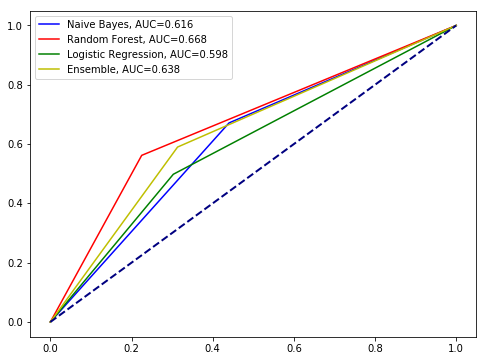

In [32]:
#plotting roc curve
y_test = [ i if (i==1) else 0 for i in y_test  ]

plt.figure()
plt.subplots(figsize=(8,6))

y_predGNB = [ i if (i==1) else 0 for i in y_predGNB  ]
fpr, tpr, _ = roc_curve(y_test, y_predGNB, pos_label=1)
plt.plot(fpr, tpr, 'b', label="Naive Bayes, AUC=" + str(round(roc_auc_score(y_test, y_predGNB), 3)))

y_predRFC = [ i if (i==1) else 0 for i in y_predRFC ]
fpr, tpr, _ = roc_curve(y_test, y_predRFC)
plt.plot(fpr, tpr, 'r', label="Random Forest, AUC=" + str(round(roc_auc_score(y_test, y_predRFC), 3)))

y_predLR = [ i if (i==1) else 0 for i in y_predLR  ]
fpr, tpr, _ = roc_curve(y_test, y_predLR)
plt.plot(fpr, tpr, 'g', label="Logistic Regression, AUC=" + str(round(roc_auc_score(y_test, y_predLR), 3)))

y_predEnsem = [ i if (i==1) else 0 for i in y_predEnsem  ]
fpr, tpr, _ = roc_curve(y_test, y_predEnsem)
plt.plot(fpr, tpr, 'y', label="Ensemble, AUC=" + str(round(roc_auc_score(y_test, y_predEnsem), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.show()